# Markov generation of wine reviews

## Questions: 
- Is it rendering properly in github? 

## TODO
- App to choose real or fake

In [1]:
import numpy as np 
import pandas as pd 

import random
import re 
import string

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
df = pd.read_csv('../input/winemag-data_first150k.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
# add some relevant data
df['description_length'] = df.description.apply(lambda x: len(re.findall("(\S+)", x)))

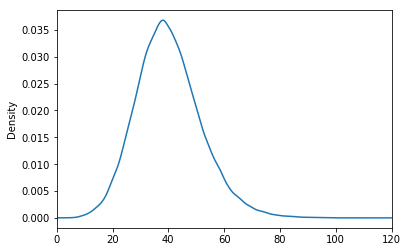

In [4]:
df.description_length.plot.kde(xlim=(0,120))

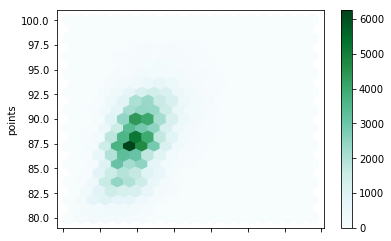

In [5]:
df.plot.hexbin('description_length', 'points', gridsize=20)

In [6]:
description_list = df.description.tolist()

In [7]:
def get_first_two_words(mystring:str):
    mylist = mystring.split(" ")
    return mylist[0], mylist[1] 

def make_prefix_dict(words:list):
    prefix = {}
    for i in range(len(words)-2):
        if (words[i], words[i+1]) not in prefix:
            prefix[(words[i], words[i+1])] = []
        prefix[(words[i], words[i+1])].append(words[i+2])
    return prefix
    
class AI_Sommelier():
    
    def __init__(self, descriptions:list, subset=100):
        if subset:
            self.descriptions = descriptions[:subset]
        self.description_starts = [get_first_two_words(d) for d in self.descriptions]
        self.description_lengths = [len(re.findall("(\S+)", d)) for d in self.descriptions]
        self.description_words = ' '.join(self.descriptions)
        # NOTE - it's better at least for now to leave in punctuation rather than strip it
        # self.description_words = ''.join([x + '' for x in self.descriptions if x in string.ascii_letters  + '\'- '])
        self.words = self.description_words.split(" ")
        self.prefix = make_prefix_dict(self.words)
        
    def sample_review(self, seed=0):
        random.seed(seed)
        return random.choice(self.descriptions)
        
    def write_review(self, seed=0):
        random.seed(seed)
        # Note - currently these lengths will be longer than real review, because
        # review lenghts are being assigned to min_length
        min_words = random.choice(self.description_lengths)
        
        current_pair = random.choice(self.description_starts)
        random_text = current_pair[0] + ' ' + current_pair[1]

        i = 2 #already have two words
        uncompleted = True
        while uncompleted:
            # last two words in document may not have a suffix
            if current_pair not in self.prefix:
                break
            next_word = random.choice(self.prefix[current_pair])
            # make sure we end with a (somewhat) complete sentence
            if i >= min_words:
                if '.' in next_word: uncompleted = False
            random_text = random_text + ' ' + next_word
            current_pair = (current_pair[1], next_word)
            i += 1

        return random_text
        

In [8]:
sommelier = AI_Sommelier(description_list, subset=10_000)

# Compare random samples and markov generation

In [9]:
for i in range(0,4):
    print(f'SAMPLE REVIEW \n {sommelier.sample_review(seed=i)} \n')
    print(f'GENERATE REVIEW \n {sommelier.write_review(seed=i)} \n')

SAMPLE REVIEW 
 Graphite, maple and other oaky aromas dominate this lush, pitch-black Tinto Fino. A chewy, dense mouthfeel is rich as an oil baron, while oak-driven flavors of vanilla and baking spices accent blackberry and cassis. On the finish, this is monster-sized and full of blue-fruit deliciousness. Drink through 2020. 

GENERATE REVIEW 
 Josmeyer's organic wines give a lot of enjoyment. This wine made by refermenting with partially dried grapes, this is firm, juicy palate delivers wild cherry, ripe strawberry, providing a soft, rich mouthfeel coats the fresh fruitiness of the vintage. Drink this powerful and concentrated, the finish this is light in color and ripe berries suffuse the palate, spicing up the strawberry, blueberry and plum. 

SAMPLE REVIEW 
 This is attractive in a bright, fruit-driven style. Bright berry fruit is tinged with apricot and cocoa on the midpalate, then finishes firm and dusty. 

GENERATE REVIEW 
 This wine features an enticing floral character, this i

# Prefix Investigation
- What are some common and rare prefixes (ie, where is the branching occuring)
- How does the word mapping change with increaing # of training examples? 
- What percentage are "stubs" (ie, the prefix only has one suffix)
- What is the mean suffix percentage

In [10]:
def make_prefix_dataframe(prefix:dict):
    df_prefix = pd.DataFrame(columns=['prefix', 'suffix'])
    df_prefix['prefix'] = prefix.keys()
    df_prefix['suffix'] = prefix.values()
    df_prefix['suffix_length'] = df_prefix.suffix.apply(lambda x: len(x))
    return df_prefix

### It seems that a lot of branching is happening before nouns or adjectives, which makes sense

In [11]:
sommelier = AI_Sommelier(description_list, subset=10000)
df_prefix = make_prefix_dataframe(sommelier.prefix)
prefix_sorted = df_prefix.sort_values('suffix_length', ascending=False).reset_index()
prefix_sorted.head()

,index,prefix,suffix,suffix_length
0,85,"(on, the)","[palate,, palate, palate,, lees, velvety, prop...",2393
1,19,"(and, a)","[compelling, subtle, lemony, complex, whiff, w...",1878
2,335,"(with, a)","[hint, burst, menthol-like, warm, warm,, dash,...",1563
3,269,"(is, a)","[wine, winner., key, wine, major, magnificent,...",1350
4,60,"(aromas, of)","[fig,, grilled, black-olive, hazelnut, scorche...",1192


In [12]:
prefix_sorted.tail()

,index,prefix,suffix,suffix_length
133232,69850,"(fairly, complex)",[on],1
133233,69849,"(yeasty, flavors,)",[while],1
133234,69848,"(briny, apple,)",[nectarine],1
133235,20367,"(feel,, tapering)",[on],1
133236,133236,"(like, strawberry)",[jam.],1


In [13]:
def compare_prefix_dataframes(subsets=[100,1000]):
    df_compare = pd.DataFrame(columns=['subset', 'suffix_length_mean', 'suffix_stub_perc'], index=range(0,len(subsets)))
    for i, s in enumerate(subsets):
        sommelier = AI_Sommelier(description_list, subset=s)
        df_prefix = make_prefix_dataframe(sommelier.prefix)
        df_compare.loc[i, 'subset'] = s
        df_compare.loc[i, 'suffix_length_mean'] = df_prefix.suffix_length.mean()
        df_compare.loc[i, 'suffix_stub_perc'] = len(df_prefix.loc[df_prefix["suffix_length"] == 1]) / len(df_prefix) * 100
    return df_compare

### The percentage of prefixes that are "stubs" (ie, only have one prefix) decreases steadily, while mean suffix length increases

In [14]:
df_compare = compare_prefix_dataframes(subsets=[100, 1000, 10_000, 50_000, 100_000, 150_000])
df_compare

,subset,suffix_length_mean,suffix_stub_perc
0,100,1.26023,88.0702
1,1000,1.7817,77.3152
2,10000,3.01894,68.8668
3,50000,4.52275,62.8098
4,100000,5.97589,53.1724
5,150000,7.57016,41.5606


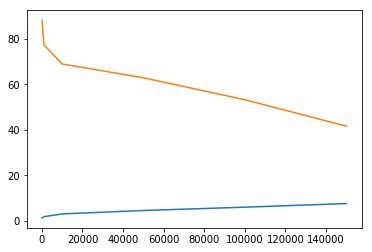

In [15]:
plt.plot(df_compare.subset, df_compare.suffix_length_mean)
plt.plot(df_compare.subset, df_compare.suffix_stub_perc)

### The distributions shift as expected as more training examples are used

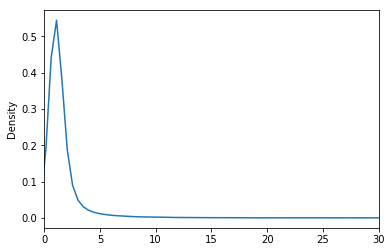

In [16]:
sommelier = AI_Sommelier(description_list, subset=1000)
df_prefix = make_prefix_dataframe(sommelier.prefix)
df_prefix.suffix_length.plot.kde(xlim=(0,30))

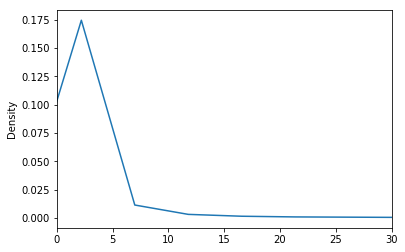

In [17]:
sommelier = AI_Sommelier(description_list, subset=10_000)
df_prefix = make_prefix_dataframe(sommelier.prefix)
df_prefix.suffix_length.plot.kde(xlim=(0,30))